In [1]:
import mlflow
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType
import pandas as pd

In [2]:


# Search all runs across all experiments
# This returns a pandas DataFrame
all_runs = mlflow.search_runs(search_all_experiments=True)

print(f"Found {len(all_runs)} runs")
print(all_runs.head())


Found 784 runs
                             run_id       experiment_id    status  \
0  178ecd4f3d034cd6a1b06b71873ac38d  106748991110785308  FINISHED   
1  0d003301eba64277977612010defbf08  106748991110785308  FINISHED   
2  042f6197acf44d91bd4a20217376d6ae  106748991110785308  FINISHED   
3  08fba9825461461ea6776d49d8999e3d  106748991110785308  FINISHED   
4  32cd55ae2828428a9db4870a04ea4e8c  106748991110785308  FINISHED   

                                        artifact_uri  \
0  file:///Users/jannis/PycharmProjects/class-imb...   
1  file:///Users/jannis/PycharmProjects/class-imb...   
2  file:///Users/jannis/PycharmProjects/class-imb...   
3  file:///Users/jannis/PycharmProjects/class-imb...   
4  file:///Users/jannis/PycharmProjects/class-imb...   

                        start_time                         end_time  \
0 2025-11-12 05:42:56.652000+00:00 2025-11-12 05:43:01.247000+00:00   
1 2025-11-12 05:42:52.367000+00:00 2025-11-12 05:42:56.651000+00:00   
2 2025-11-12 05:42:4

In [3]:
print(all_runs.columns)

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.recall', 'metrics.val_loss', 'metrics.accuracy',
       'metrics.f1_score', 'metrics.roc_auc', 'metrics.precision',
       'metrics.train_loss', 'params.gamma', 'params.config_version',
       'params.imbalance_ratio', 'params.hidden_size', 'params.test_size',
       'params.epochs', 'params.learning_rate', 'params.num_samples',
       'params.noise', 'params.batch_size', 'params.num_layers',
       'params.loss_function', 'params.val_size', 'params.alpha',
       'params.dataset', 'params.ce_weight', 'tags.mlflow.user',
       'tags.mlflow.source.name', 'tags.mlflow.runName',
       'tags.mlflow.source.type', 'tags.mlflow.source.git.commit'],
      dtype='object')


In [4]:
all_runs.describe()

,metrics.recall,metrics.val_loss,metrics.accuracy,metrics.f1_score,metrics.roc_auc,metrics.precision,metrics.train_loss
count,784.000000,784.000000,784.000000,784.000000,784.000000,784.000000,784.000000
mean,0.694357,0.354601,0.839509,0.540624,0.904498,0.502520,0.207436
std,0.364904,1.042078,0.186432,0.333270,0.073949,0.345671,0.516994
min,0.000000,0.000009,0.236800,0.000000,0.658400,0.000000,0.000004
25%,0.459000,0.005623,0.755909,0.314286,0.833456,0.227058,0.002193
50%,0.900000,0.019422,0.910909,0.556439,0.904416,0.500000,0.009988
75%,0.980000,0.084307,0.990099,0.836066,0.988510,0.816993,0.059101
max,1.000000,11.592515,1.000000,1.000000,1.000000,1.000000,2.715843


In [5]:
#Find best F1 Score model for dataset with noise 0.1 and imbalance_ratio 0.5 for each loss_fn also return the parameters for loss function aswell. Means alpha and gamma for focal and weight for wce
# Get unique noise and imbalance_ratio values
noises = all_runs['params.noise'].unique()
imbalance_ratios = all_runs['params.imbalance_ratio'].unique()

# Create results list
all_results = []

# Iterate through all combinations
for noise in noises:
    for imbalance_ratio in imbalance_ratios:
        filtered_runs = all_runs[
            (all_runs['params.noise'] == noise) &
            (all_runs['params.imbalance_ratio'] == imbalance_ratio)
        ]

        if len(filtered_runs) == 0:
            continue

        # Group by loss function and find best F1 score for each
        best_models = filtered_runs.groupby('params.loss_function').apply(
            lambda group: group.loc[group['metrics.f1_score'].idxmax()]
        ).reset_index(drop=True)

        # Extract relevant information
        for idx, row in best_models.iterrows():
            loss_fn = row['params.loss_function']

            result = {
                'noise': noise,
                'imbalance_ratio': imbalance_ratio,
                'loss_fn': loss_fn,
                'f1_score': row['metrics.f1_score'],
                'run_id': row['run_id']
            }

            # Extract loss-specific parameters
            if loss_fn == 'focal':
                result['alpha'] = row['params.alpha']
                result['gamma'] = row['params.gamma']
            elif loss_fn == 'wce':
                result['weight'] = row['params.ce_weight']

            # Add all metrics columns
            metrics_cols = [col for col in row.index if col.startswith('metrics.')]
            for metric_col in metrics_cols:
                metric_name = metric_col.replace('metrics.', '')
                result[metric_name] = row[metric_col]

            all_results.append(result)

results_df = pd.DataFrame(all_results)
print(results_df)

   noise imbalance_ratio loss_fn  f1_score                            run_id  \
0    0.9             0.5      ce  0.585366  bd710764059b48ce979ffa6daa238bec   
1    0.9             0.5   focal  0.653968  95cf7f8b45584e5f9227985097284346   
2    0.9             0.5     wce  0.589286  b2d70dfc7a4741a0b1dcbde3f66949b9   
3    0.9            0.25      ce  0.420513  7886d9a34f574f879b50d2bbc01676b3   
4    0.9            0.25   focal  0.571429  df1579df13044b0f84c64b746824b3cc   
..   ...             ...     ...       ...                               ...   
79   0.1             0.1   focal  0.989899  a336773a59264b959a140994d3594fb6   
80   0.1             0.1     wce  0.989899  c329dc90a79046238effea457404a302   
81   0.1            0.01      ce  0.571429  99412335f60a4b1f88a04a313010f96c   
82   0.1            0.01   focal  1.000000  23ae572aa1454a54ad09fb19b2bcdbee   
83   0.1            0.01     wce  1.000000  4b14bfa1712b44199753e8a1459f22cf   

    recall  val_loss  accuracy   roc_au

/var/folders/pq/7tww9h2961b0pzlfhhzbszfw0000gn/T/ipykernel_6701/1815785922.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_models = filtered_runs.groupby('params.loss_function').apply(
/var/folders/pq/7tww9h2961b0pzlfhhzbszfw0000gn/T/ipykernel_6701/1815785922.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_models = filtered_runs.groupby('params.loss_function').apply(
/var/folders/pq/7tww9h2961b0pz

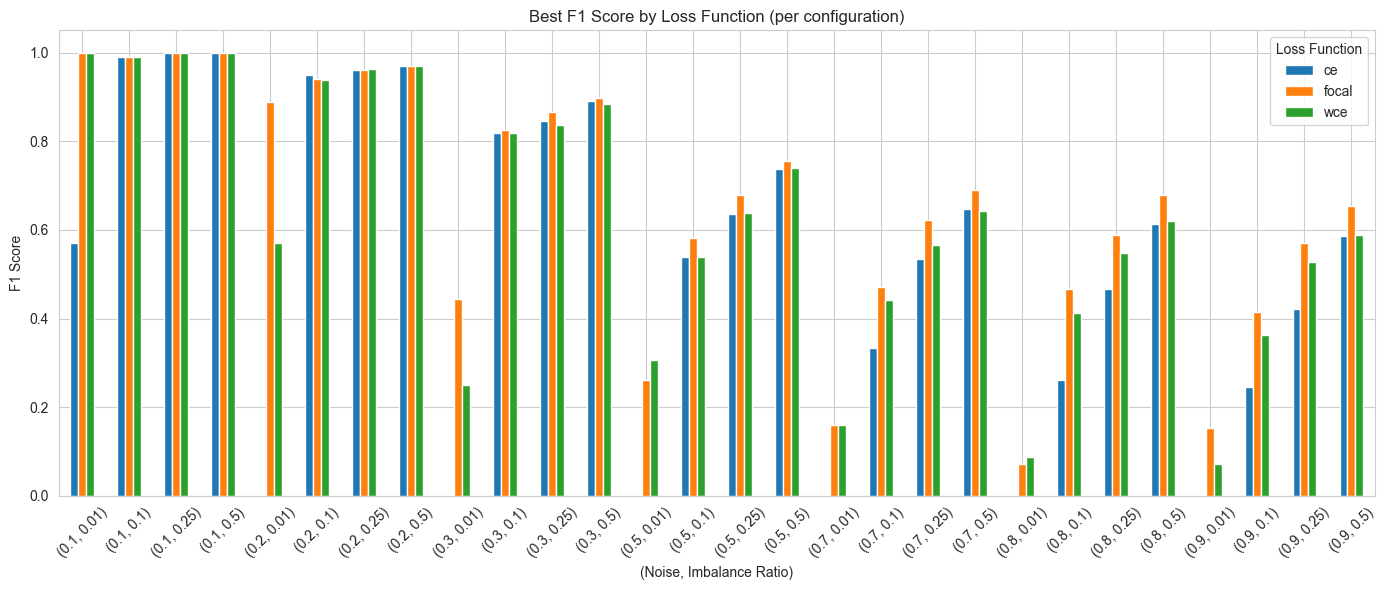

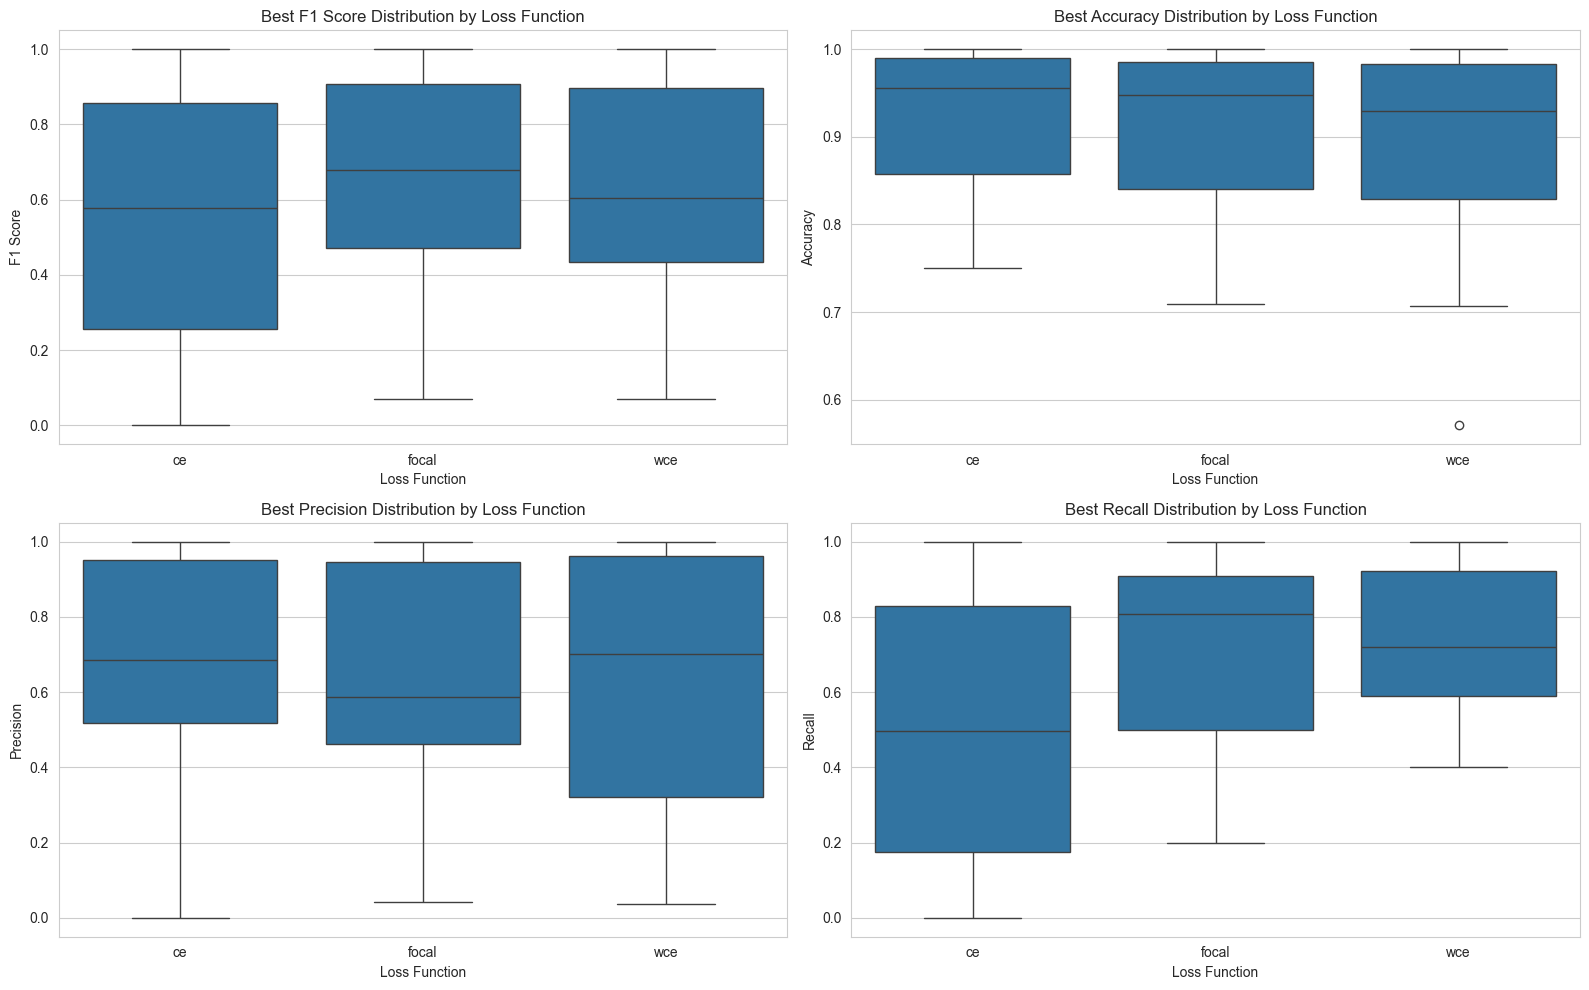

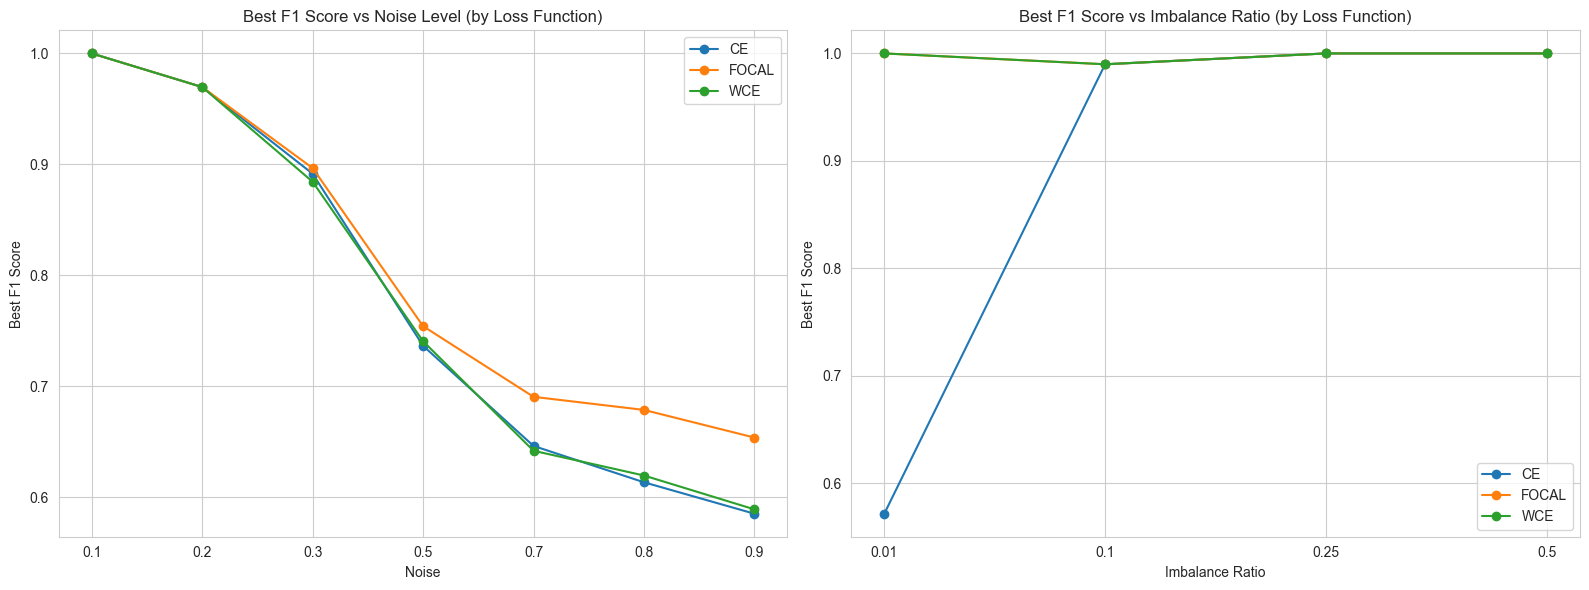

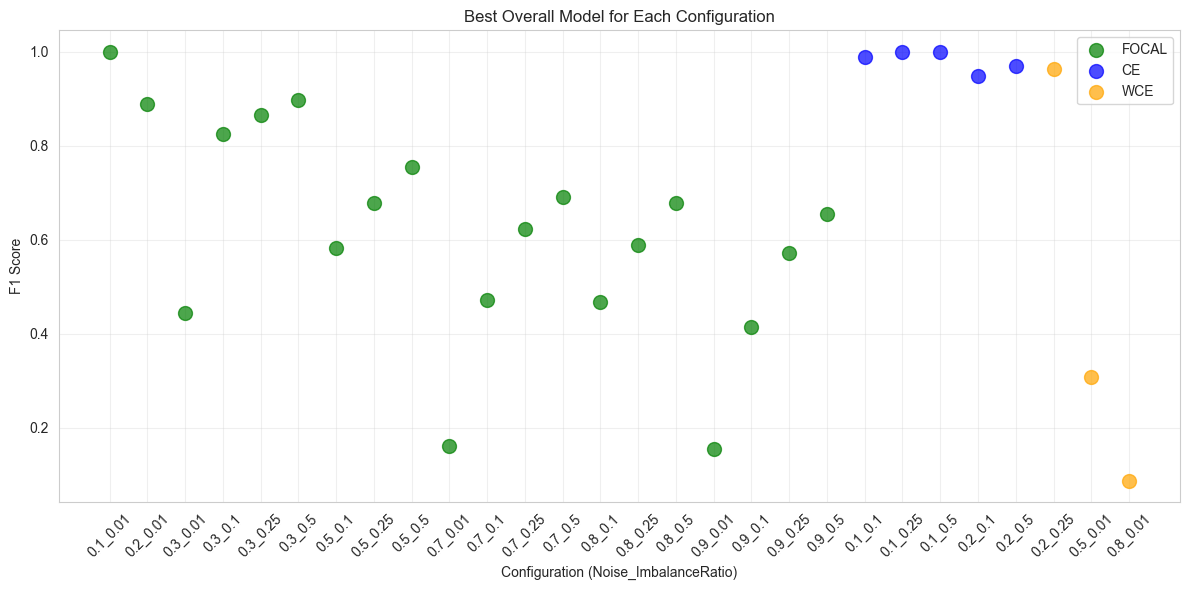

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# 1. F1 Score comparison across loss functions for each noise-imbalance combination
fig, ax = plt.subplots(figsize=(14, 6))
pivot_f1 = results_df.pivot_table(
    values='f1_score',
    index=['noise', 'imbalance_ratio'],
    columns='loss_fn',
    aggfunc='first'
)
pivot_f1.plot(kind='bar', ax=ax)
ax.set_title('Best F1 Score by Loss Function (per configuration)')
ax.set_xlabel('(Noise, Imbalance Ratio)')
ax.set_ylabel('F1 Score')
ax.legend(title='Loss Function')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# 2. Box plot comparing metrics across loss functions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
metrics_to_plot = ['f1_score', 'accuracy', 'precision', 'recall']

for i, metric in enumerate(metrics_to_plot):
    if metric in results_df.columns:
        ax = axes[i // 2, i % 2]
        sns.boxplot(data=results_df, x='loss_fn', y=metric, ax=ax)
        ax.set_title(f'Best {metric.replace("_", " ").title()} Distribution by Loss Function')
        ax.set_xlabel('Loss Function')
        ax.set_ylabel(metric.replace('_', ' ').title())

plt.tight_layout()
plt.show()

# 3. Line plot showing best F1 score trends
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# F1 vs Noise (for each loss function, show best F1 at each noise level)
for loss_fn in results_df['loss_fn'].unique():
    loss_data = results_df[results_df['loss_fn'] == loss_fn]
    grouped = loss_data.groupby('noise')['f1_score'].max()  # Best F1 at each noise level
    axes[0].plot(grouped.index, grouped.values, marker='o', label=loss_fn.upper())

axes[0].set_title('Best F1 Score vs Noise Level (by Loss Function)')
axes[0].set_xlabel('Noise')
axes[0].set_ylabel('Best F1 Score')
axes[0].legend()
axes[0].grid(True)

# F1 vs Imbalance Ratio
for loss_fn in results_df['loss_fn'].unique():
    loss_data = results_df[results_df['loss_fn'] == loss_fn]
    grouped = loss_data.groupby('imbalance_ratio')['f1_score'].max()  # Best F1 at each imbalance ratio
    axes[1].plot(grouped.index, grouped.values, marker='o', label=loss_fn.upper())

axes[1].set_title('Best F1 Score vs Imbalance Ratio (by Loss Function)')
axes[1].set_xlabel('Imbalance Ratio')
axes[1].set_ylabel('Best F1 Score')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# 4. Best overall model for each noise-imbalance combination
fig, ax = plt.subplots(figsize=(12, 6))
results_df['config'] = results_df['noise'].astype(str) + '_' + results_df['imbalance_ratio'].astype(str)
best_per_config = results_df.loc[results_df.groupby('config')['f1_score'].idxmax()]

colors = {'ce': 'blue', 'wce': 'orange', 'focal': 'green'}
for loss_fn in best_per_config['loss_fn'].unique():
    data = best_per_config[best_per_config['loss_fn'] == loss_fn]
    ax.scatter(data['config'], data['f1_score'], label=loss_fn.upper(),
               color=colors.get(loss_fn, 'gray'), s=100, alpha=0.7)

ax.set_title('Best Overall Model for Each Configuration')
ax.set_xlabel('Configuration (Noise_ImbalanceRatio)')
ax.set_ylabel('F1 Score')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
